## Images preprocessing
- manually remove images which is not clear or not a house imge
- manually label image to `like` and `unlike`
- remove image which the width/height ratio is not between 1 and 2
- resize pixel of image to 150 * 100
- convert image to pixel
- merge house features and image pixel

In [3]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

## Images labeled by like, unlike, and can not use

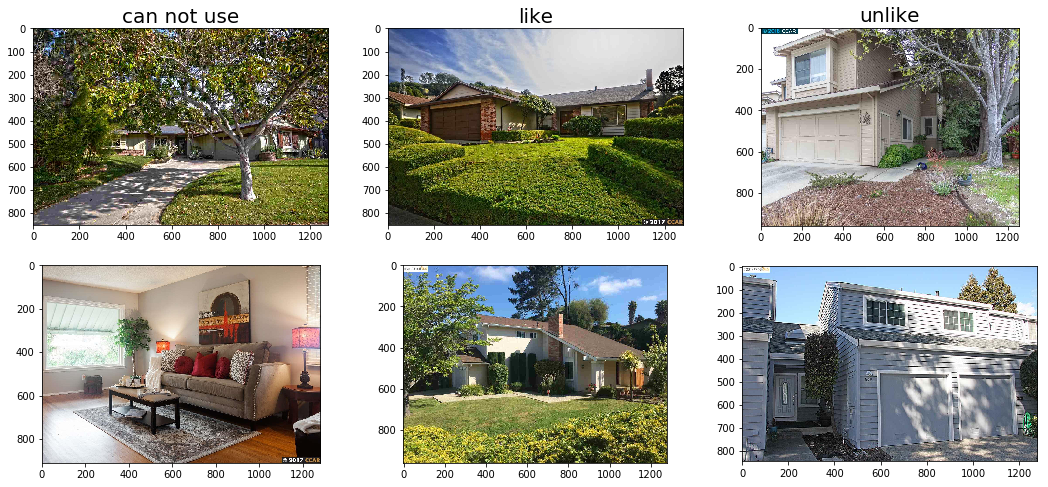

In [32]:
cannotuse1 = Image.open('origion-img/pinole_sold/can not use/40806590.JPG')
cannotuse2 = Image.open('origion-img/pinole_sold/can not use/40768318.JPG')
like1 = Image.open('origion-img/pinole_sold/like/40804232.JPG')
like2 = Image.open('origion-img/pinole_sold/like/40822137.JPG')
unlike1 = Image.open('origion-img/pinole_sold/unlike/40816362.JPG')
unlike2 = Image.open('origion-img/pinole_sold/unlike/40810709.JPG')

images = [cannotuse1, like1, unlike1, cannotuse2, like2, unlike2]
titles = ['can not use', 'like', 'unlike']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18,8))

for i in range(2):
    for j in range(3):
        if i < 1:
            axes[i,j].imshow(images[j])
            axes[i,j].set_title(titles[j],fontsize=20)
        elif i >= 1:
            axes[i,j].imshow(images[j+3])
            

In [3]:
houses = pd.read_csv('./dataset/sold_clean.csv')
print(houses.shape)
houses.head()

(1434, 10)


,id,adress,bed,bath,house size,price,zip code,city,lot size,price/sqft
0,40830101,2615 Mira Vista Dr E,4,2.0,2055,875000,94530,EL CERRITO,4800,426.0
1,40825887,840 Gelston Pl E,3,2.0,1494,953000,94530,EL CERRITO,5520,638.0
2,40824801,724 Gelston Pl E,3,2.5,2310,1050000,94530,EL CERRITO,5600,455.0
3,40821808,825 Park Way E,4,3.5,4060,1675000,94530,EL CERRITO,10700,413.0
4,40824686,8547 Terrace Dr E,5,3.5,3023,1230000,94530,EL CERRITO,17200,407.0


In [4]:
houses['city'].value_counts()

HERCULES       298
PINOLE         297
EL CERRITO     296
SAN PABLO      293
EL SOBRANTE    250
Name: city, dtype: int64

origional size:  428 * 299


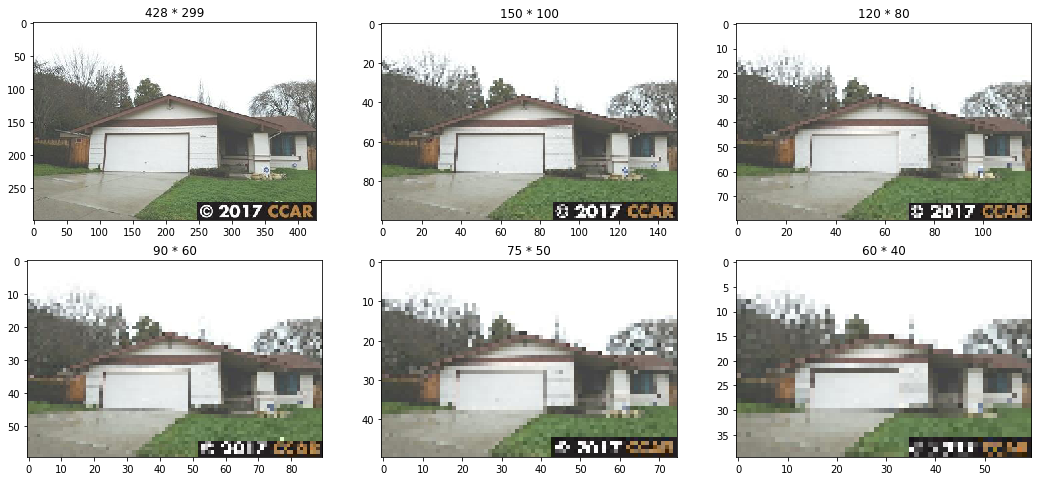

In [436]:
original_image = Image.open('origion-img/pinole_sold/like/40769355.JPG')
width, height = original_image.size
resized_image1 = original_image.resize((150, 100))
resized_image2 = original_image.resize((120, 80))
resized_image3 = original_image.resize((90, 60))
resized_image4 = original_image.resize((75, 50))
resized_image5 = original_image.resize((60, 40))

images = [original_image, resized_image1, resized_image2, resized_image3, resized_image4, resized_image5]

print('origional size: ', str(width), '*', str(height) )

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18,8))
for i, img in enumerate(images):
    width, height = img.size
    if i < 3:
        axes[0,i].imshow(img)
        axes[0,i].set_title(str(width) + ' * ' + str(height))
    elif i>= 3:
        axes[1,i-3].imshow(img)
        axes[1,i-3].set_title(str(width) + ' * ' + str(height))
        


In [1]:
# this function will convert all image information into a dataframe
# id, width, height, size, w/h ratio, pixels

def get_imgae(folder, size):

    images = glob.glob('origion-img/' + folder + '/*.JPG')

    pixel = []
    for i in range(size[0] * size[1] *3): # r, g, b
        pixel.append('pixel' + str(i))
        
    img_pixel = []

    img_id = []
    img_width = []
    img_height = []
    img_size = []
    img_wh = []
    
    for image in images:
        
        original_image = Image.open(image)
        width, height = original_image.size        
        image_name = image.replace('origion-img/' + folder + '/','')
        
        # reshape image to size
        resized_image = original_image.resize(size)
        
        # split to r, g, b
        r, g, b = resized_image.split()
        re_size = size[0] * size[1]
        r_arr = np.array(r).reshape(re_size)
        g_arr = np.array(g).reshape(re_size)
        b_arr = np.array(b).reshape(re_size)
        image_arr = np.concatenate((r_arr, g_arr, b_arr))
        img_pixel.append(image_arr)
        
        img_id.append(int(image_name[-12:-4]))
        img_width.append(width)
        img_height.append(height)
        img_size.append(width*height)
        img_wh.append(round(width/height, 1))

        #print(image_name[-12:-4], 'is %4d wide'%(width), 'x %4d high'%(height) ) 
        
    df_pixel = pd.DataFrame(np.array(img_pixel), columns = pixel)        
    df_img = pd.DataFrame({'id': img_id, 
                           'width': img_width, 
                           'height': img_height,
                           'size': img_size,
                           'w/h': img_wh})    
    df = pd.concat([df_img, df_pixel], axis = 1)
        
    return df

In [56]:
def combine(folder, size, merge):
    
    # convert image in both like & unlike folders to dataframe
    like = get_imgae(folder + '/like', size)
    like['label'] = 1
    unlike = get_imgae(folder + '/unlike', size)
    unlike['label'] = 0
    
    # concatenate and drop duplicates
    df = pd.concat([like, unlike], ignore_index=True)
    print('orginal', df.shape)
    df.drop_duplicates(subset=['id'], keep=False)
    print('drop_duplicates', df.shape)
    
    # count how many rows of data in df 
    length = df.shape[0]
    
    # remove images which the w/h ratio is between 1 and 2
    df_remove = df[(df['w/h'] >= 1.0) & (df['w/h'] <= 2.0)]
    df_remove.reset_index(drop=True, inplace=True)
    print('w/h ratio between 1 and 2', df.shape)
    
    # merge with house features
    final = pd.merge(merge, df_remove, on=['id'])
    print('merge with house features', final.shape)
    print('missing: ', set(df_remove['id']) - set(final['id']))
    
    # make sure pixel in datadrame can build original image
    arr = np.array(final.iloc[68,14:size[0]*size[1]*3+14]).reshape(3, size[1], size[0]).astype('float32')
    r = Image.fromarray(arr[0]).convert('L')
    g = Image.fromarray(arr[1]).convert('L')
    b = Image.fromarray(arr[2]).convert('L')
    image = Image.merge("RGB", (r, g, b))
        
    fig, axes = plt.subplots(ncols=2, figsize=(10,4))
    axes[0].imshow(image)
    axes[1].hist(df['w/h'])
    axes[1].set_title(str(final.shape[0]) +  '/' + str(length)) 
    axes[1].axvline(x=1., ls='--', c='orange')
    axes[1].axvline(x=2., ls='--', c='orange');
        
    return final

orginal (276, 1806)
drop_duplicates (276, 1806)
w/h ratio between 1 and 2 (276, 1806)
merge with house features (268, 1815)
missing:  {40784888}


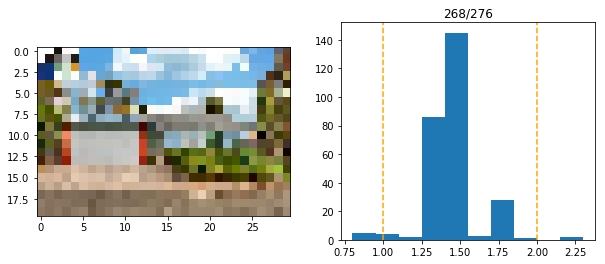

In [57]:
df30X20 = combine('pinole_sold', (30, 20), houses)
df30X20.to_csv('./dataset/pinole30x20.csv', index=False)

orginal (276, 7206)
drop_duplicates (276, 7206)
w/h ratio between 1 and 2 (269, 7206)
merge with house features (268, 7215)
missing:  {40784888}


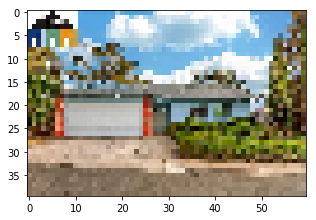

In [462]:
df60X40 = combine('pinole_sold', 'PINOLE', (60, 40), houses)
df60X40.to_csv('./dataset/pinole60x40.csv', index=False)

orginal (276, 28806)
drop_duplicates (276, 28806)
w/h ratio between 1 and 2 (269, 28806)
merge with house features (268, 28815)
missing:  {40784888}


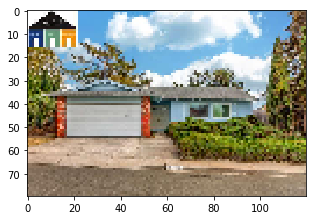

In [463]:
df120X80 = combine('pinole_sold', (120, 80), houses)
df120X80.to_csv('./dataset/pinole120x80.csv', index=False)

orginal (230, 28806)
drop_duplicates (230, 28806)
w/h ratio between 1 and 2 (227, 28806)
merge with house features (225, 28815)
missing:  {40782658, 40785461}


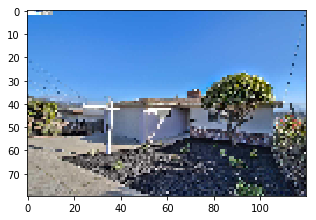

In [12]:
df120X80 = combine('elcerrito_sold', (120, 80), houses)
df120X80.to_csv('./dataset/pinole120x80.csv', index=False)

orginal (230, 45006)
drop_duplicates (230, 45006)
w/h ratio between 1 and 2 (227, 45006)
merge with house features (225, 45015)
missing:  {40782658, 40785461}


1    0.662222
0    0.337778
Name: label, dtype: float64

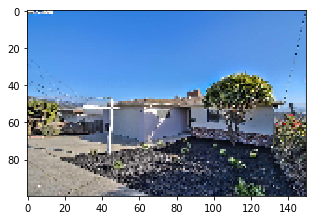

In [23]:
elcerrito = combine('elcerrito_sold', (150, 100), houses)
elcerrito.to_csv('./dataset/elcerrito150x100.csv', index=False)
elcerrito['label'].value_counts(normalize=True)


orginal (178, 45006)
drop_duplicates (178, 45006)
w/h ratio between 1 and 2 (173, 45006)
merge with house features (173, 45015)
missing:  set()


1    0.583815
0    0.416185
Name: label, dtype: float64

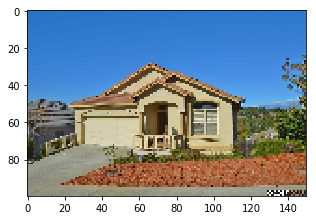

In [21]:
elsobrante = combine('elsobrante_sold', (150, 100), houses)
elsobrante.to_csv('./dataset/elsobrante150x100.csv', index=False)
elsobrante['label'].value_counts(normalize=True)

orginal (276, 45006)
drop_duplicates (276, 45006)
w/h ratio between 1 and 2 (269, 45006)
merge with house features (268, 45015)
missing:  {40784888}


1    0.746269
0    0.253731
Name: label, dtype: float64

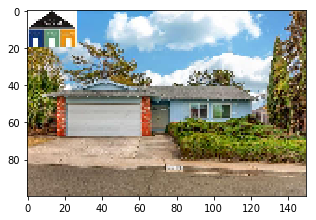

In [24]:
pinole = combine('pinole_sold', (150, 100), houses)
pinole.to_csv('./dataset/pinole150x100.csv', index=False)
pinole['label'].value_counts(normalize=True)

orginal (249, 45006)
drop_duplicates (249, 45006)
w/h ratio between 1 and 2 (231, 45006)
merge with house features (229, 45015)
missing:  {40783795, 40777652}


0    0.681223
1    0.318777
Name: label, dtype: float64

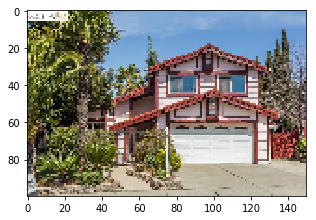

In [25]:
hercules = combine('hercules_sold', (150, 100), houses)
hercules.to_csv('./dataset/hercules150x100.csv', index=False)
hercules['label'].value_counts(normalize=True)

orginal (242, 45006)
drop_duplicates (242, 45006)
w/h ratio between 1 and 2 (225, 45006)
merge with house features (222, 45015)
missing:  {40763443, 40788885, 40754639}


1    0.756757
0    0.243243
Name: label, dtype: float64

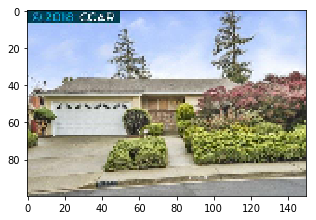

In [32]:
sanpablo = combine('sanpablo_sold', (150, 100), houses)
sanpablo.to_csv('./dataset/sanpablo150x100.csv', index=False)
sanpablo['label'].value_counts(normalize=True)

In [39]:
sanpablo.columns[0:14]

Index(['id', 'adress', 'bed', 'bath', 'house size', 'price', 'zip code',
       'city', 'lot size', 'price/sqft', 'width', 'height', 'size', 'w/h'],
      dtype='object')

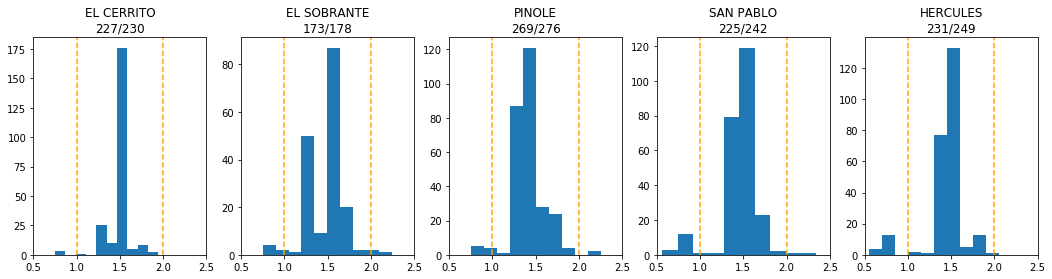

In [48]:
folder1 = ['elcerrito_sold', 'elsobrante_sold', 'pinole_sold', 'sanpablo_sold', 'hercules_sold']
city_name = ['EL CERRITO', 'EL SOBRANTE', 'PINOLE', 'SAN PABLO', 'HERCULES']

fig, axes = plt.subplots(ncols=5, figsize=(18,4))

for i, city in enumerate(folder1):
    
    like = 'origion-img/' + city + '/like/*.JPG'
    unlike = 'origion-img/' + city + '/unlike/*.JPG'

    list_ratio = []
    count = 0
    
    for _ in [like, unlike]:
        images = glob.glob(_)
        for image in images:
            original_image = Image.open(image)
            width, height = original_image.size
            ratio = width/height
            list_ratio.append(ratio)
            
            if (ratio >= 1) & (ratio <= 2):
                count += 1
    
    axes[i].hist(list_ratio)
    axes[i].set_title(city_name[i] + '\n' + str(count) +  '/' + str(len(list_ratio)))
    axes[i].set_xlim(0.5, 2.5)
    axes[i].axvline(x=1., ls='--', c='orange')
    axes[i].axvline(x=2., ls='--', c='orange');
    